# Machine Learning Engineer Nanodegree
## Model Evaluation & Validation
## Project: Predicting Boston Housing Prices

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started
In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

In [10]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Calculate Descriptive Statistics 

These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In [11]:
# Minimum price of the data
minimum_price = np.amin(prices)

# Maximum price of the data
maximum_price = np.amax(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:,.2f}".format(minimum_price))
print("Maximum price: ${:,.2f}".format(maximum_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


### Feature Observation

Using our intuition, for each of the three features above, we can try to understand if an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'.

- RM should increase near 3-4 rooms but not much near 7-8, because there is not much difference between 250 m2 or 270 m2. 
- LSTAT must be the must important feature, because in poor neighborhoood demande for houses is lower and prices are cheaper.
- PTRATIO is less "important" feauture among those 3, but still can be influential - in good neighborhoods, there is more of infrastructure and schools are less saturated, and in good neighborhoods prices are higher.

## Developing a Model


### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify our model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

In [12]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Implementation: Shuffle and Split Data
Our next implementation requires that we take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating.

In [13]:
# Import 'train_test_split'
from sklearn.cross_validation import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=0)

# Success
print("Training and testing split was successful.")
X_train.info()


Training and testing split was successful.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 447 to 172
Data columns (total 3 columns):
RM         391 non-null float64
LSTAT      391 non-null float64
PTRATIO    391 non-null float64
dtypes: float64(3)
memory usage: 12.2 KB


----

## Analyzing Model Performance
In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, we'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing our model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Run the code cell below and use these graphs to answer the following question.

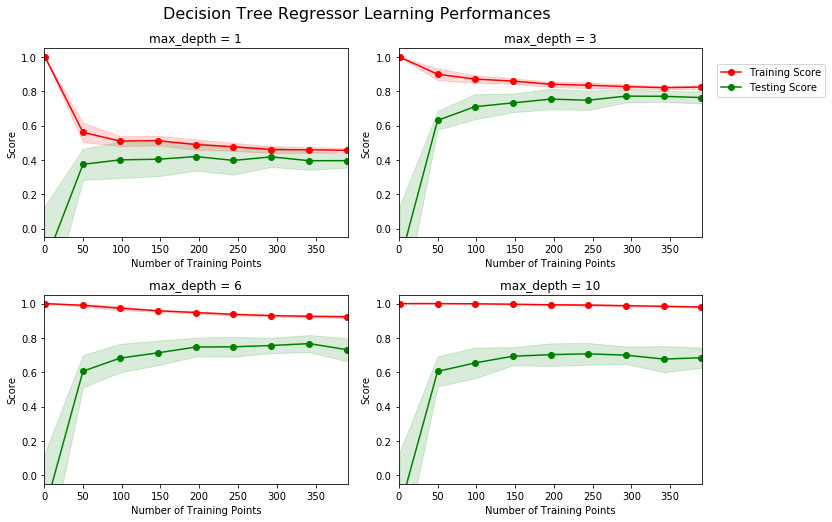

In [14]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Observations

- The best model uses max_depth=3. Also the shaded area looks thiner, wich means less unsertanty in the model.
- When we add more training points the training score goes down a little but then converges slowly to 0.8. The testing score goes up rapidly around 50 points and slowly converge to 0.8.
- After 200 points models seems to stay around 0.8 and adding more points dosent affect it performance.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.

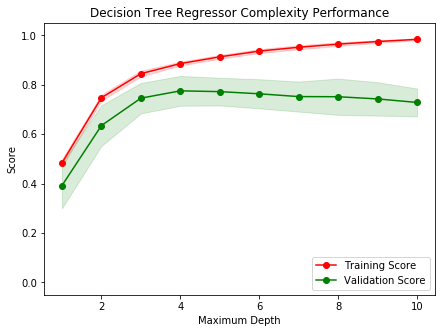

In [15]:
vs.ModelComplexity(X_train, y_train)

### Observations
- When the model is trained with a maximum depth of 1, the model suffer from high bias. It means the model dosen't capture well the variance in data, and generalise to much (model is not complex enough to pick up the nuances in the data). So when used on the test set the score is low.

- When the model is trained with a maximum depth of 10, the model have high variance - a sign of overfitting(model is by-hearting the data and cannot generalize well) and starts to "remember" , the validation scoore goes down because the model with hight variance can't generalise well on new data.

-----

## Evaluating Model Performance
In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`. We will use Grid Search and Cross-Validation.

### Grid Search
Grid Search technique is used when you have many possible models, which differ from each other in their parameter values, it look like some kind of spreadsheet (for 2 values). By training and evaluating each model (using cross-validation and estimation metrics)we can compare and select the best among all models.

### Cross-Validation
The k-fold cross-validation training is technique of splitting data in 3 sets (randomly):
- Training to train a model
- Cross validation to tune the paramaters of the model
- Testing to test the performance of the model

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

KFold divides all the samples in k groups of samples, called folds (if k = n, this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using k - 1 folds, and the fold left out is used for test.

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.

### Implementation: Fitting a Model
Our final implementation requires to train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In [16]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state=0)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': [i for i in range(1, 11)]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**.

In [17]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


### Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would we recommend each client sell his/her home at? 

In [18]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $391,183.33
Predicted selling price for Client 2's home: $189,123.53
Predicted selling price for Client 3's home: $942,666.67


### Recommendations

Predicted selling price for Client 1's home: $391,183.33
- When compared to the closest entry in dataset (5.272	16.14	14.7 275100.0) the house seems a bit overpriced (by 100000) but we have also "worst" houses priced 100000 more (207	5.412	29.55	18.6	497700.0)

Predicted selling price for Client 2's home: $189,123.53
- The closest entry in dataset is 367	4.368	30.63	20.2	184800.0, so I think the price is rather fair.

Predicted selling price for Client 3's home: $942,666.67
- This house can be priced a little bit more, when compared to the entrys in dataset, we can add another 50000.

These prices seem reasonable given the values for the respective features but we need more features to price houses correctly.

In [19]:
data1 = data[(data.RM > 7.5) & (data.RM < 8.5) & (data.LSTAT < 5) & (data.PTRATIO < 20)]
data1.sort(['MEDV'], axis=0, ascending=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,RM,LSTAT,PTRATIO,MEDV
218,8.040,3.13,17.4,789600.0
97,8.069,4.21,18.0,812700.0
224,8.337,2.47,17.4,875700.0
196,7.610,3.11,14.7,888300.0
245,8.259,3.54,19.1,898800.0
98,7.820,3.57,18.0,919800.0
217,8.266,4.14,17.4,940800.0
270,7.820,3.76,14.9,953400.0
272,7.645,3.01,14.9,966000.0
220,7.686,3.92,17.4,980700.0


### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**

In [20]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $424,935.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $73,357.39


### Conclusion

- Data was collected from 1978, the dollar 30 years ago not the same as today. We need to conver the prices to today "standart". Considering inflation is very important!
- We need way more factors to accurately price a home. The factors like quality of apppliances in the home, square feet of the plot area, presence of pool etc... should also factor in.
- If would price a house base only on 3 features this is robust enough to make consistent predictions.
- Data collected in an urban city like Boston could be applicable in a rural city in some degre. But we need to take in consideration other factors to make a consistent predictions.